In [5]:
!pip install pyts



In [6]:
import numpy as np
import matplotlib.pyplot as plt
from pyts.decomposition import SingularSpectrumAnalysis
import scipy.io as sc
from scipy.signal import stft, bode, butter, lfilter,freqz
from scipy import signal

# Diferentes Filtros

In [7]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_lowpass(cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)    
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y
def butter_lowpass_bode (b ,a):
    angularFreq, freqResponse, phaseResponse = scipy.signal.bode(scipy.signal.lti(b, a))

    return angularFreq, freqResponse, phaseResponse

def butter_bandpass_bode (b ,a):
    angularFreq, freqResponse, phaseResponse = scipy.signal.bode(scipy.signal.lti(b, a))

    return angularFreq, freqResponse, phaseResponse

# Sismo Local

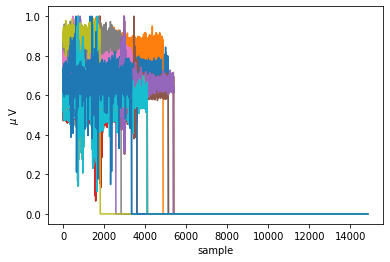

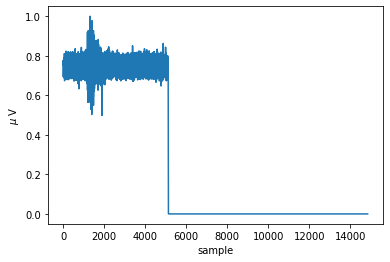

In [8]:
dataLoc = sc.loadmat('sisLoc.mat')#retorna los datos que lee de matlab
dataLoc.keys() # variables del diccionario

Y = dataLoc['Y']# variables
fs1 = dataLoc['fs']#frecuencia de emuestreo que regista el acelerometro

plt.plot(Y.T)#trasponer
plt.xlabel('sample')
plt.ylabel('$\mu$ V')
plt.show()
sampleSignal = Y[0,:] # se extrae una señal de la base de datos
plt.figure
plt.plot(sampleSignal)
plt.xlabel('sample')
plt.ylabel('$\mu$ V')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


<Figure size 432x288 with 0 Axes>

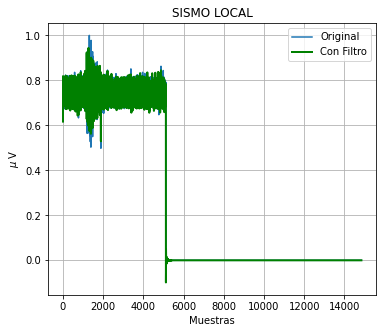

In [9]:
#------------------------------------------------------fILTRADO
fs = 102.0 #Debe cumplir el principio de Nyquist
lowcut = 1
highcut = 50
order = 6

signalFilteredLoc = np.zeros((21,14848))

for i in range(0,21):
  signalFilteredLoc[i,:] = butter_lowpass_filter(Y[i,:],highcut, fs, order)

plt.figure()
plt.figure(figsize=(20,5))
plt.subplot(1,3,1), plt.plot(Y[0,:], label='Original');
plt.subplot(1,3,1), plt.plot(signalFilteredLoc[0,:],'g',linewidth=2, label='Con Filtro');
plt.title("SISMO LOCAL"), plt.xlabel('Muestras'),plt.ylabel('$\mu$ V')
plt.grid()
plt.legend()




<Figure size 432x288 with 0 Axes>

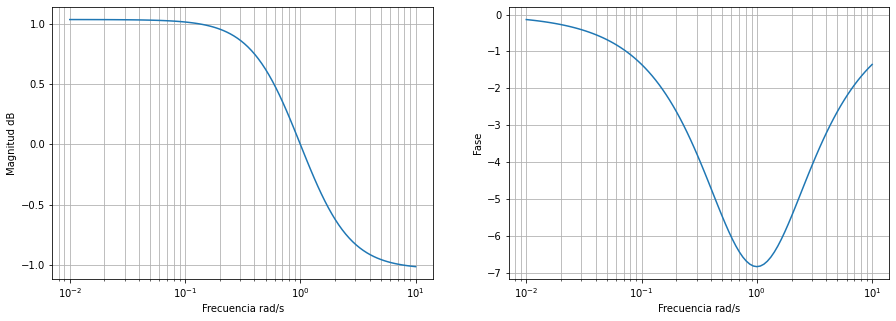

In [10]:

b,a= butter_lowpass(highcut, fs,order)
sys = (b,a) # Creamos el sistema
w, mag, phase = signal.bode(sys) # Diagrama de bode: frecuencias, magnitud y fase


#plt.semilogx(w, mag) # Eje x logarítmico
#plt.semilogx(w, phase) # Eje x logarítmico

plt.figure()
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.semilogx(w,mag)
plt.xlabel('Frecuencia rad/s')
plt.ylabel('Magnitud dB')
plt.grid(True, which="both")

plt.subplot(1,2,2)
plt.semilogx(w,phase)
plt.xlabel('Frecuencia rad/s')
plt.ylabel('Fase')
plt.grid(True, which="both")



## Separar las señales

<function matplotlib.pyplot.show>

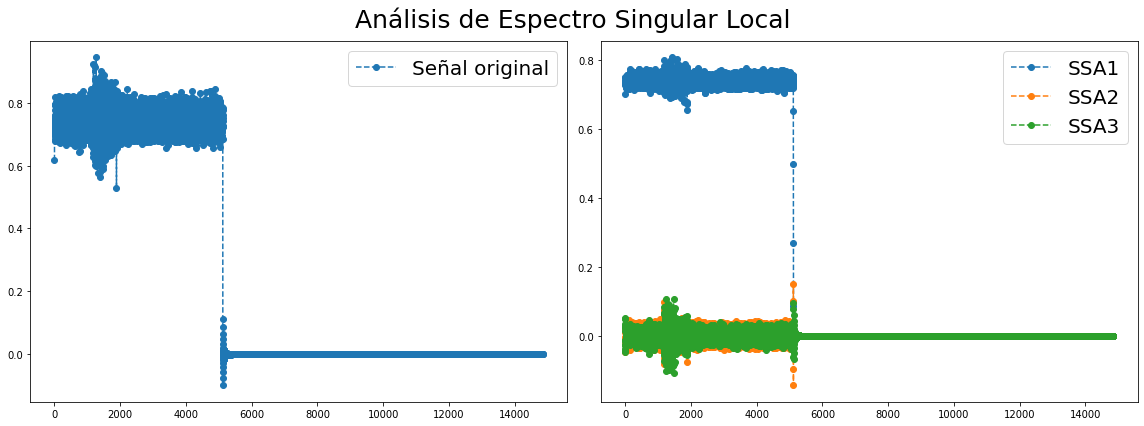

In [11]:
LOCAL = signalFilteredLoc
Grup= 3
SSA= SingularSpectrumAnalysis(window_size=Grup)
LOCALssa = SSA.fit_transform(signalFilteredLoc)
plt.figure(figsize=(16,6))
idsignal = 0
plt.suptitle('Análisis de Espectro Singular Local',fontsize=25)

ax1=plt.subplot(121)
ax1.plot(LOCAL[idsignal], 'o--', label= 'Señal original')
ax1.legend(loc='best', fontsize=20)
ax2=plt.subplot(122)
for i in range(Grup):
  ax2.plot(LOCALssa[idsignal, i],'o--', label= 'SSA{0}'.format(i+1))
ax2.legend(loc='best', fontsize=20)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show

(<matplotlib.axes._subplots.AxesSubplot at 0x7fe158e5a610>,
 [<matplotlib.lines.Line2D at 0x7fe157bdbb90>])

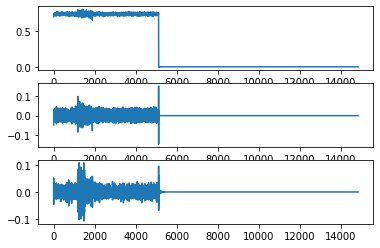

In [12]:
plt.subplot(3,1,1),plt.plot(LOCALssa[idsignal, 0])
plt.subplot(3,1,2),plt.plot(LOCALssa[idsignal, 1])
plt.subplot(3,1,3),plt.plot(LOCALssa[idsignal, 2])

STFT para las 3 señales: 3


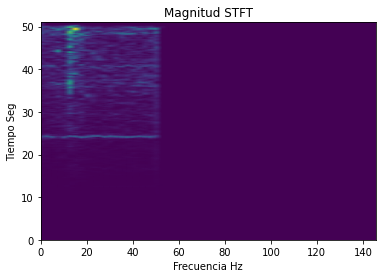

In [27]:
#-----------------------------------------------Analisis en Frecuencia
#STFT
#for i in range (0,21):
print('STFT para las 3 señales:', i+1)
  #for j in range (0,3):
f,t,Zxx= signal.stft(LOCALssa[0,2],fs,nperseg=512)
absZxx = np.abs(Zxx)
plt.pcolormesh(t,f,absZxx, shading='gouraud')
plt.title('Magnitud STFT')
plt.xlabel('Frecuencia Hz')
plt.ylabel('Tiempo Seg')
plt.show()


In [ ]:
def extract_features(Zxx, f, ssa):
  # En la matriz Zxx se tiene una matriz de #defrecs * #times
  # Zxx[i,j], sería el espectro en la frecuencia[i] y el tiempo [j]  
  absZxx = np.abs(Zxx)
  maxP = np.max(absZxx)
  id = np.where(absZxx==maxP)
  frecPmax = np.squeeze(f[id[0]])
  energy=signalEnergy(ssa)
  maxF = np.max(absZxx,axis=1)
  meanP = np.mean(maxF)
  varP = np.var(maxF)
  maxSpectrum = np.max(maxF)
  minSpectrum = np.min(maxF)

  #Funcion para el cálculo de la energía.
def signalEnergy(signalInput):  
  sum = 0
  for k in range(len(signalInput)):
    sum+=pow(signalInput[k],2)     
  sigEnergy = sum
  return sigEnergy 

# Sismo Regional

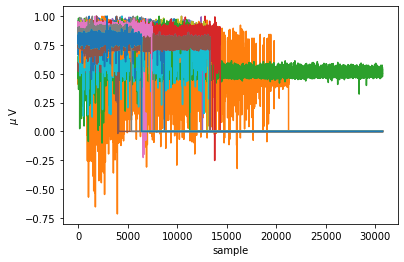

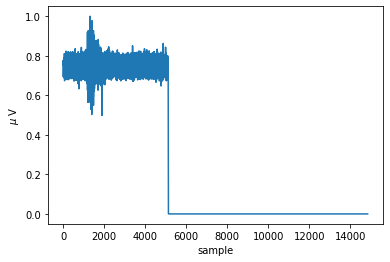

In [14]:
dataReg = sc.loadmat('sisReg.mat')#retorna los datos que lee de matlab
dataReg.keys() # variables del diccionario

X = dataReg['Y']#Son variables
fs = dataReg['fs']#frecuencia de emuestreo que regista el acelerometro

plt.plot(X.T)#trasponer
plt.xlabel('sample')
plt.ylabel('$\mu$ V')
plt.show()

sampleSignal = Y[0,:] # se extrae una señal de la base de datos
plt.figure
plt.plot(sampleSignal)
plt.xlabel('sample')
plt.ylabel('$\mu$ V')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


<Figure size 432x288 with 0 Axes>

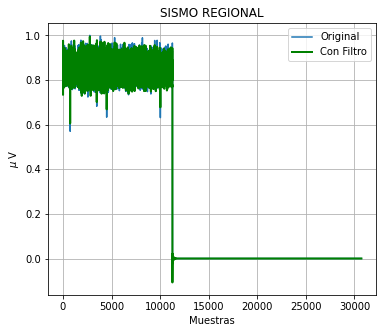

In [15]:
#------------------------------------------------------fILTRADO
fs = 102.0 #Debe cumplir el principio de Nyquist
lowcut = 1
highcut = 50
order = 6

signalFilteredReg = np.zeros((21,30720))

for i in range(0,21):
  signalFilteredReg[i,:] = butter_lowpass_filter(X[i,:],highcut, fs, order)

plt.figure()
plt.figure(figsize=(20,5))
plt.subplot(1,3,1), plt.plot(X[0,:], label='Original');
plt.subplot(1,3,1), plt.plot(signalFilteredReg[0,:],'g',linewidth=2, label='Con Filtro');
plt.title("SISMO REGIONAL"), plt.xlabel('Muestras'),plt.ylabel('$\mu$ V')
plt.grid()
plt.legend()

<function matplotlib.pyplot.show>

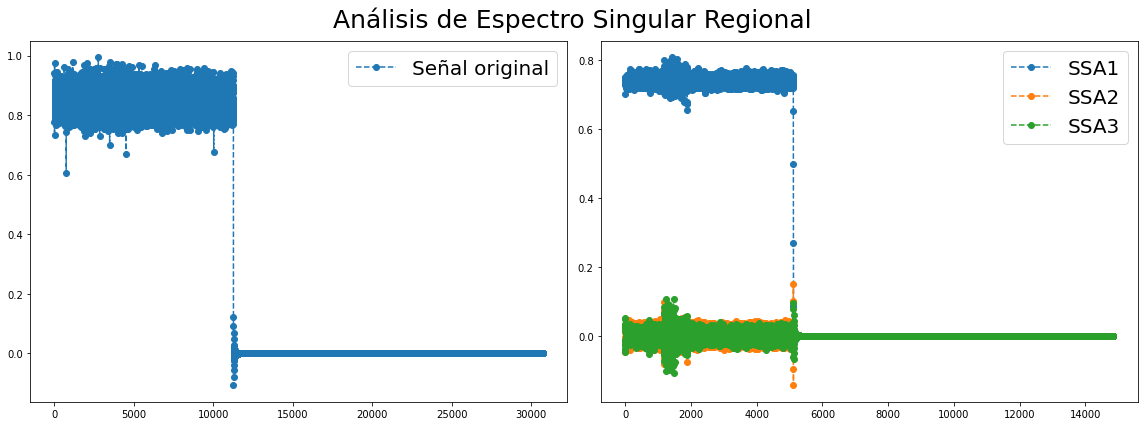

In [16]:
REGIONAL = signalFilteredReg
Grup1= 3
SSA1= SingularSpectrumAnalysis(window_size=Grup1)
REGIONALssa = SSA1.fit_transform(signalFilteredLoc)
plt.figure(figsize=(16,6))
idsignal = 0
plt.suptitle('Análisis de Espectro Singular Regional',fontsize=25)

ax1=plt.subplot(121)
ax1.plot(REGIONAL[idsignal], 'o--', label= 'Señal original')
ax1.legend(loc='best', fontsize=20)
ax2=plt.subplot(122)
for i in range(Grup1):
  ax2.plot(REGIONALssa[idsignal, i],'o--', label= 'SSA{0}'.format(i+1))
ax2.legend(loc='best', fontsize=20)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show

(<matplotlib.axes._subplots.AxesSubplot at 0x7fe14f0a8b50>,
 [<matplotlib.lines.Line2D at 0x7fe14f024250>])

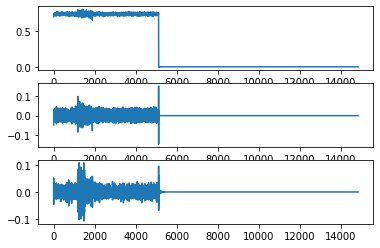

In [17]:
plt.subplot(3,1,1),plt.plot(REGIONALssa[idsignal, 0])
plt.subplot(3,1,2),plt.plot(REGIONALssa[idsignal, 1])
plt.subplot(3,1,3),plt.plot(REGIONALssa[idsignal, 2])

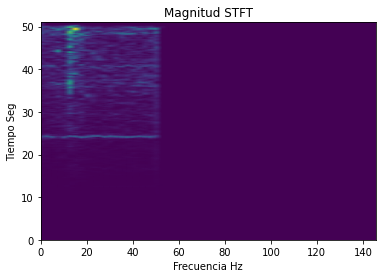

In [18]:
#-----------------------------------------------Analisis en Frecuencia
#STFT
#for i in range (0,21):
  #print('STFT para las 3 señales:', i+1)
  #for j in range (0,3):
f,t,Zxx= signal.stft(REGIONALssa[0,2],fs,nperseg=512)
absZxx = np.abs(Zxx)
plt.pcolormesh(t,f,absZxx, shading='gouraud')
plt.title('Magnitud STFT')
plt.xlabel('Frecuencia Hz')
plt.ylabel('Tiempo Seg')
plt.show()

# Sismo Tele

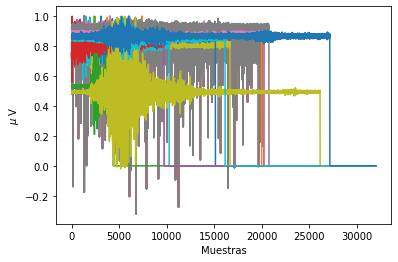

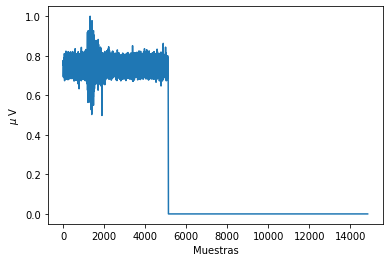

In [19]:
dataTele = sc.loadmat('sisTele.mat')#retorna los datos que lee de matlab
dataReg.keys() # variables del diccionario

Z = dataTele['Y']#Son variables
fs3 = dataTele['fs']#frecuencia de emuestreo que regista el acelerometro

plt.plot(Z.T)#trasponer
plt.xlabel('Muestras')
plt.ylabel('$\mu$ V')
plt.show()

sampleSignal = Y[0,:] # se extrae una señal de la base de datos
plt.figure
plt.plot(sampleSignal)
plt.xlabel('Muestras')
plt.ylabel('$\mu$ V')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


<Figure size 432x288 with 0 Axes>

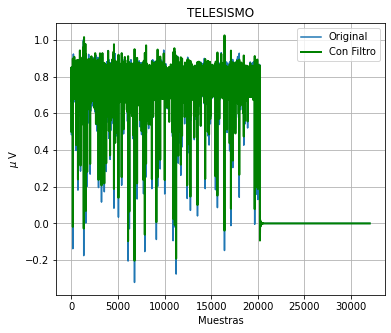

In [20]:
#------------------------------------------------------fILTRADO
fs = 102.0 #Debe cumplir el principio de Nyquist
lowcut = 1
highcut = 50
order = 6

signalFilteredTele = np.zeros((21,32000))

for i in range(0,21):
  signalFilteredTele[i,:] = butter_lowpass_filter(Z[i,:],highcut, fs, order)

plt.figure()
plt.figure(figsize=(20,5))
plt.subplot(1,3,1), plt.plot(Z[0,:], label='Original');
plt.subplot(1,3,1), plt.plot(signalFilteredTele[0,:],'g',linewidth=2, label='Con Filtro');
plt.title("TELESISMO"), plt.xlabel('Muestras'),plt.ylabel('$\mu$ V')
plt.grid()
plt.legend()

<function matplotlib.pyplot.show>

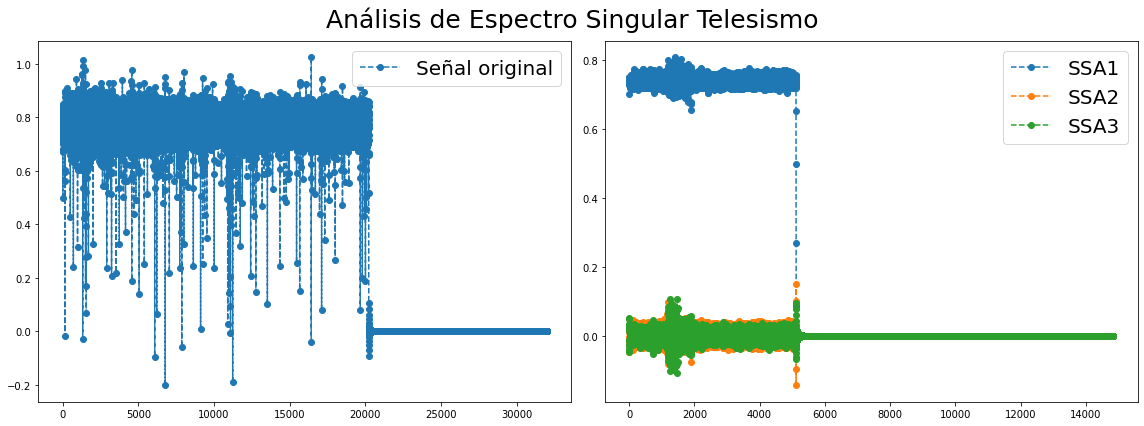

In [21]:
TELESISMO = signalFilteredTele
Grup2= 3
SSA2= SingularSpectrumAnalysis(window_size=Grup2)
TELESISMOssa = SSA2.fit_transform(signalFilteredLoc)
plt.figure(figsize=(16,6))
idsignal = 0
plt.suptitle('Análisis de Espectro Singular Telesismo',fontsize=25)

ax1=plt.subplot(121)
ax1.plot(TELESISMO[idsignal], 'o--', label= 'Señal original')
ax1.legend(loc='best', fontsize=20)
ax2=plt.subplot(122)
for i in range(Grup2):
  ax2.plot(TELESISMOssa[idsignal, i],'o--', label= 'SSA{0}'.format(i+1))
ax2.legend(loc='best', fontsize=20)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show

(<matplotlib.axes._subplots.AxesSubplot at 0x7fe158e2d890>,
 [<matplotlib.lines.Line2D at 0x7fe157dc7690>])

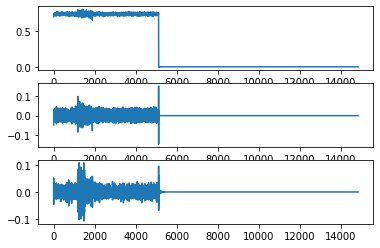

In [22]:
plt.subplot(3,1,1),plt.plot(TELESISMOssa[idsignal, 0])
plt.subplot(3,1,2),plt.plot(TELESISMOssa[idsignal, 1])
plt.subplot(3,1,3),plt.plot(TELESISMOssa[idsignal, 2])

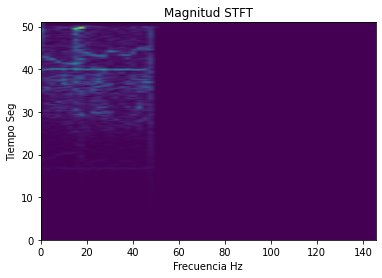

In [23]:
#-----------------------------------------------Analisis en Frecuencia
#STFT
#for i in range (0,21):
  #print('STFT para las 3 señales:', i+1)
  #for j in range (0,3):
f,t,Zxx= signal.stft(TELESISMOssa[1,2],fs,nperseg=512)
absZxx = np.abs(Zxx)
plt.pcolormesh(t,f,absZxx, shading='gouraud')
plt.title('Magnitud STFT')
plt.xlabel('Frecuencia Hz')
plt.ylabel('Tiempo Seg')
plt.show()

# Descomponer Funciones